In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import math
import random
import sklearn
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from matplotlib import rcParams
#import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds


## CLEANING USER DATASET

In [2]:
# Loading in User playtime data
dataframe = pd.read_csv('steam-200k.csv')
dataframe = dataframe.set_axis(['UserID' , 'Game', 'Purchase/Play','Hrs played', '0/1'], axis = 1)

# Cleaning data

# Removing weird symbols that appear often in game titles + creating a collumn with the newly cleaned names
names2 = []
for i in dataframe["Game"]:
  names2.append(i.replace('®' , '').replace('™' , '').lower())
dataframe['p_names'] = names2  

# Removing games with 'DLC' in their title, as they are not useful
dlcs = []
for i in dataframe['p_names']:
  if 'dlc' in i:
    dlcs.append(i)
dlcs = np.unique(dlcs)  

# Removing special editions/versions of games 
editions = []
for i in dataframe['p_names']:
  if 'edition' in i:
    editions.append(i)
editions = np.unique(editions) 

# Removing season passes
seasonpass = []
for i in dataframe['p_names']:
  if 'season' in i:
    seasonpass.append(i)
seasonpass = np.unique(seasonpass) 

# Dropping both DLCs and special editions
for i in dlcs:
  dataframe.drop(dataframe[dataframe['p_names']==i].index, inplace=True)
for i in editions:
  dataframe.drop(dataframe[dataframe['p_names']==i].index, inplace=True)
for i in seasonpass:
  dataframe.drop(dataframe[dataframe['p_names']==i].index, inplace=True)


In [6]:
# Creating a collumn Hours_played where we only include the playtime, so that the 'purchase' rows can be dropped later on
dataframe['Hours_Played'] = dataframe['Hrs played'].astype('float32')


dataframe.loc[(dataframe['Purchase/Play'] == 'purchase') & (dataframe['Hrs played'] == 1.0), 'Hours_Played'] = 0

In [8]:
# Drop the 'purchase' rows
clean_df = dataframe.drop_duplicates(['UserID', 'Game'], keep = 'last').drop(['Purchase/Play', 'Hrs played','0/1', 'Game'], axis = 1)
top_10_games = clean_df['p_names'].value_counts()[0:10]

# Drop all game titles that are played less than 25 hours as they are useless for generating recommendations
tot_hrs_p_game = clean_df.groupby('p_names').sum()
tot_hrs_p_game.drop(tot_hrs_p_game[tot_hrs_p_game['Hours_Played']>25].index, inplace=True)
all_useless_games = np.unique(tot_hrs_p_game.index.get_level_values(0))
for i in all_useless_games:
  clean_df.drop(clean_df[clean_df['p_names']==i].index, inplace=True)

## CALCULATING RATINGS BASED ON PLAYTIME PER PERSON

In [5]:
# Creating a collumn with all mean gametimes per game
mean_gametime = clean_df.groupby('p_names').mean()
mean_gametime = dict(mean_gametime[ 'Hours_Played'])
avg_playtimes = []
for i in clean_df['p_names']:
  avg_playtimes.append(mean_gametime[i])
clean_df['avg_playtime'] = avg_playtimes

# Creating a list of the hours per player to calculate ratings
hours_p_player = list(clean_df['Hours_Played'])
avg_hours = list(clean_df['avg_playtime'])


In [6]:
# Calculating ratings based on the game time per player compared to the mean game time of that game
ratings = []
for i in range(0,len(hours_p_player)):
  if hours_p_player[i]/avg_hours[i] > 1:
    ratings.append(5)
  elif hours_p_player[i]/avg_hours[i] > 0.8:
    ratings.append(4)
  elif hours_p_player[i]/avg_hours[i] > 0.5:
    ratings.append(3)
  elif hours_p_player[i]/avg_hours[i] > 0.1:
    ratings.append(2)
  else:
    ratings.append(1)  

clean_df['rating'] = ratings

In [7]:
# Creating usefull variables for later on
n_users = len(np.unique(clean_df['UserID']))
n_games = len(np.unique(clean_df['p_names']))
user_list = np.unique(clean_df['UserID'])
item_list = np.unique(clean_df['p_names'])

## CLEANING STEAM GAMES DATASET

In [8]:
# Loading in the steam games dataset
dataframe1 = pd.read_csv('steam.csv')
dataframe2 = pd.read_csv('steam_requirements_data.csv')
dataframe1 = dataframe1.rename(columns={'appid': 'steam_appid'})
dataframe1 = pd.merge(dataframe1,dataframe2, on='steam_appid')

# Stripping the game names of weird symbols
names = []
for i in dataframe1['name']:
  names.append(i.replace('®' , '').replace('™' , '').replace(':', '').replace('’' , "'").lower())
dataframe1['p_names'] = names

names2 = []
for i in dataframe["Game"]:
  names2.append(i.replace('®' , '').replace('™' , '').lower())
dataframe['p_names'] = names2  

In [9]:
# Dropping features I wont be using
dataframe1 = dataframe1.drop(['english', 'publisher','achievements', 'positive_ratings','required_age', 'price', 'negative_ratings', 'average_playtime', 'median_playtime', 'owners', 'pc_requirements', 'mac_requirements', 'linux_requirements', 'minimum', 'recommended'], axis=1)

In [10]:
# Creating the metadata feature where all usefull features are merged into one feature
dataframe1['metadata'] = dataframe1['developer'].str.replace(' ', '') + ','+ dataframe1['platforms'].str.replace(';',' ')+ ',' + dataframe1['categories'].str.replace(';',' ')+ ',' + dataframe1['genres'].str.replace(';',' ')+ ',' + dataframe1['steamspy_tags'].str.replace(';',' ')
dataframe1['metadata'] = dataframe1['metadata'].str.replace(',', ' ').replace(';',' ')

dataframe1['metadata'][4].lower()

'gearboxsoftware windows mac linux single-player multi-player valve anti-cheat enabled action fps action sci-fi'

## MATCHING DATASETS

In [11]:
# Matching the player dataset with the steam dataset
all_found_games = []
for i in dataframe1['p_names']:
    if i not in item_list:
        dataframe1 = dataframe1.drop(dataframe1[dataframe1['p_names'] == i].index)
    else:
        all_found_games.append(i)

In [12]:
# Dropping all games that are not in the games dataset
for i in clean_df['p_names']:
    if i not in all_found_games:
        clean_df = clean_df.drop(clean_df[clean_df['p_names']==i].index) 

In [13]:
# Adding the steam ID's of the games to the Userdataset which makes it easier to work with
steam_appid = []
for item in clean_df['p_names']:
    steam_appid.append(dataframe1.loc[dataframe1['p_names'] == item].index)
    
    

In [14]:
list2 = []
for i in steam_appid:
    for j in dataframe1['steam_appid'].loc[i].values:
        list2.append(j)
clean_df['steam_appid'] = list2


## PREPARATION FOR THE MODEL

In [17]:
# Renaming the columns for easier use of the model
clean_df = clean_df.rename(columns={'steam_appid':'contentId', 'UserID':'personId', 'rating':'eventStrength'})

In [18]:
dataframe1 = dataframe1.rename(columns={'steam_appid':'contentId'})

In [19]:
# Renaming the dataset for easier use of the model
interactions_df = clean_df
articles_df = dataframe1

In [21]:
# Only use users that have more than 5 games in their library

users_interactions_count_df = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# users: 5490
# users with at least 5 interactions: 2814


In [22]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 64872
# of interactions from users with at least 5 interactions: 57579


In [360]:
# Optional function to smooth the ratings of the users with a log function.
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))


# of unique user/item interactions: 57579


In [361]:
# Splitting data in train/test set
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 46063
# interactions on Test set: 11516


In [362]:
#Indexing by personId to speed up the searches during evaluation

interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

## MODEL EVALUATOR 


In [364]:
# Simple function that checks all games in a users library

def get_items_interacted(person_id, interactions_df):
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [365]:
### MODEL EVALUATOR ###

EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100
class ModelEvaluator:

    # Get all non interacted games
    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)
    # Check if the recommended items are in the top-n
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        # Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        # For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            # Getting a random sample (100) items the user has not interacted 
            # (to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            # Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        # Recall is the rate of the interacted  items that are ranked among the Top-N recommended items, 
        # when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator() 


## ACTUAL MODEL

In [366]:
# Creating user-item interaction matrix
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)



In [368]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values

In [369]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[5250, 76767, 86540, 103360, 144736, 181212, 229911, 298950, 299153, 381543]

In [370]:
# Converting the UI Matrix to a csr matrix due to memory limitations
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<2814x943 sparse matrix of type '<class 'numpy.float64'>'
	with 46063 stored elements in Compressed Sparse Row format>

In [371]:
#The number of factors to factor the user-item matrix.

NUMBER_OF_FACTORS_MF = 10

#Performs matrix factorization of the original user item matrix

U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [372]:
### CHECK ###
print(sigma)
print(U.shape)
print(Vt.shape)

array([ 37.03894747,  38.05852417,  38.92903436,  40.63700178,
        42.1168313 ,  45.57305649,  47.60246673,  57.54575685,
        72.21538925, 130.77249817])

In [375]:
sigma = np.diag(sigma)
sigma.shape


(10, 10)

In [376]:
# Dot product of all generated matrices, to create the matrix that predicts the ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 


In [377]:
# Normalize the Matrix
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [1]:
# Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()


NameError: name 'pd' is not defined

## RECOMMENDER

In [379]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[[ 'contentId', 'p_names']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, articles_df)

## RESULTS OF MODEL

In [380]:
## Checking results of the model ##
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
2813 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.5047759638763459, 'recall@10': 0.6379819381729768}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
45,23,34,61,0.377049,0.557377,62990992
206,14,23,50,0.280000,0.460000,30246419
266,16,26,49,0.326531,0.530612,53875128
388,20,30,48,0.416667,0.625000,11403772
225,24,31,48,0.500000,0.645833,22301321
...,...,...,...,...,...,...
1937,1,1,1,1.000000,1.000000,26101823
1938,1,1,1,1.000000,1.000000,577614
1940,0,1,1,0.000000,1.000000,98265922
1945,0,0,1,0.000000,0.000000,19668647


In [151]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(articles_df, how = 'left', 
                                                      left_on = 'contentId', 
                                                      right_on = 'contentId') \
                          .sort_values('eventStrength', ascending = False)[['eventStrength', 
                                                                          'contentId',
                                                                          'p_names']]

In [169]:
## Check the games in the test set ##
inspect_interactions(144736, test_set=False).head(20)

,eventStrength,contentId,p_names
0,1,130,half-life blue shift
1,1,50,half-life opposing force
2,1,70,half-life
3,1,10,counter-strike


In [166]:
## Check if the recommendations make sense ##
cf_recommender_model.recommend_items(144736, topn=10, verbose=True)

,contentId,p_names
0,220,half-life 2
1,340,half-life 2 lost coast
2,240,counter-strike source
3,380,half-life 2 episode one
4,730,counter-strike global offensive
5,420,half-life 2 episode two
6,400,portal
7,10,counter-strike
8,320,half-life 2 deathmatch
9,570,dota 2


### GRAPH OF ALL MODELS

In [289]:
### PLOTTING RESULTS OF ALL MODELS ###
barWidth = 0.15
labels = ['recall@5', 'recall@10']
content = [0.24,0.44]
content_descr = [0.15,0.36]
collab_10 = [0.44, 0.60]
collab_7 = [0.48, 0.61]
collab_7_log = [0.50, 0.64]
x = np.arange(len(labels))

In [290]:
r1 = x
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]



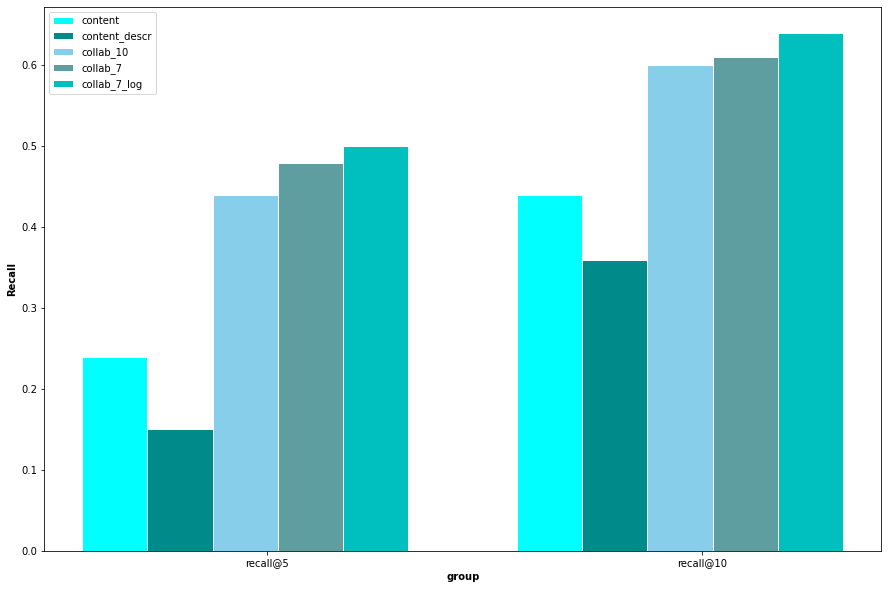

In [317]:
plt.figure(figsize=(15,10))
plt.bar(r1, content, color='cyan', width=barWidth, edgecolor='white', label='content')
plt.bar(r2, content_descr, color='darkcyan', width=barWidth, edgecolor='white', label='content_descr')
plt.bar(r3, collab_10, color='skyblue', width=barWidth, edgecolor='white', label='collab_10')
plt.bar(r4, collab_7, color='cadetblue', width=barWidth, edgecolor='white', label='collab_7')
plt.bar(r5, collab_7_log, color='c', width=barWidth, edgecolor='white', label='collab_7_log')
plt.xlabel('group', fontweight='bold')
plt.ylabel('Recall', fontweight='bold')
plt.xticks([0.35,1.35],['recall@5', 'recall@10'] )

plt.legend()
plt.show()
